In [11]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# Loading Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
valid_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='extra', download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 182040794/182040794 [00:18<00:00, 9933169.89it/s] 


100%|██████████| 64275384/64275384 [00:07<00:00, 8969930.25it/s] 


100%|██████████| 1329278602/1329278602 [02:47<00:00, 7958828.93it/s] 


In [3]:
# Define Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3*32*32),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 3, 32, 32)
        return x

In [4]:
# Training and validation
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 20
train_losses, valid_losses = [], []

for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0
    for data in train_loader:
        inputs, _ = data
        noisy_inputs = inputs + 0.2 * torch.randn_like(inputs)
        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    autoencoder.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data in valid_loader:
            inputs, _ = data
            noisy_inputs = inputs + 0.2 * torch.randn_like(inputs)
            outputs = autoencoder(noisy_inputs)
            loss = criterion(outputs, inputs)
            valid_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    valid_losses.append(valid_loss/len(valid_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Valid Loss: {valid_loss/len(valid_loader):.4f}')

Epoch [1/20], Train Loss: 0.0303, Valid Loss: 0.0224
Epoch [2/20], Train Loss: 0.0178, Valid Loss: 0.0161
Epoch [3/20], Train Loss: 0.0146, Valid Loss: 0.0137
Epoch [4/20], Train Loss: 0.0131, Valid Loss: 0.0125
Epoch [5/20], Train Loss: 0.0122, Valid Loss: 0.0115
Epoch [6/20], Train Loss: 0.0115, Valid Loss: 0.0111
Epoch [7/20], Train Loss: 0.0108, Valid Loss: 0.0103
Epoch [8/20], Train Loss: 0.0104, Valid Loss: 0.0102
Epoch [9/20], Train Loss: 0.0101, Valid Loss: 0.0107
Epoch [10/20], Train Loss: 0.0100, Valid Loss: 0.0111
Epoch [11/20], Train Loss: 0.0097, Valid Loss: 0.0093
Epoch [12/20], Train Loss: 0.0094, Valid Loss: 0.0092
Epoch [13/20], Train Loss: 0.0093, Valid Loss: 0.0089
Epoch [14/20], Train Loss: 0.0091, Valid Loss: 0.0091
Epoch [15/20], Train Loss: 0.0090, Valid Loss: 0.0091
Epoch [16/20], Train Loss: 0.0090, Valid Loss: 0.0086
Epoch [17/20], Train Loss: 0.0089, Valid Loss: 0.0085
Epoch [18/20], Train Loss: 0.0088, Valid Loss: 0.0084
Epoch [19/20], Train Loss: 0.0087, Va

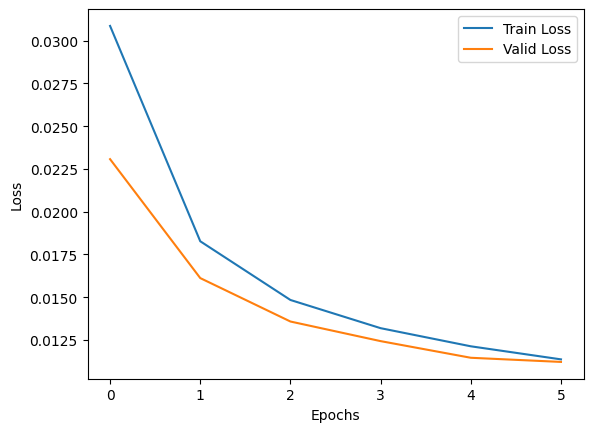

In [12]:
# Train valid loss plot
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
# Evaluation on test dataset with performance
autoencoder.eval()
test_loss = 0.0
num_correct = 0
total_samples = 0
ssim_score = 0.0
psnr_value = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        noisy_inputs = inputs + 0.2 * torch.randn_like(inputs)
        outputs = autoencoder(noisy_inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

        # Calculate accuracy
        total_samples += inputs.size(0)
        num_correct += (torch.abs(outputs - inputs) < 0.5).sum().item()

        # Calculate SSIM and PSNR
        for i in range(inputs.size(0)):
            ssim_score += ssim(inputs[i].permute(1, 2, 0).numpy(), outputs[i].permute(1, 2, 0).numpy(), multichannel=True)
            psnr_value += psnr(inputs[i].permute(1, 2, 0).numpy(), outputs[i].permute(1, 2, 0).numpy())

accuracy = num_correct / total_samples
average_ssim = ssim_score / total_samples
average_psnr = psnr_value / total_samples

print(f'Test Loss: {test_loss/len(test_loader):.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Average SSIM: {average_ssim:.4f}')
print(f'Average PSNR: {average_psnr:.4f}')

<ipython-input-17-df9b2453f52a>:23: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(inputs[i].permute(1, 2, 0).numpy(), outputs[i].permute(1, 2, 0).numpy(), multichannel=True)


Test Loss: 0.0131
Accuracy: 306303.97%
Average SSIM: 0.7502
Average PSNR: 26.1321


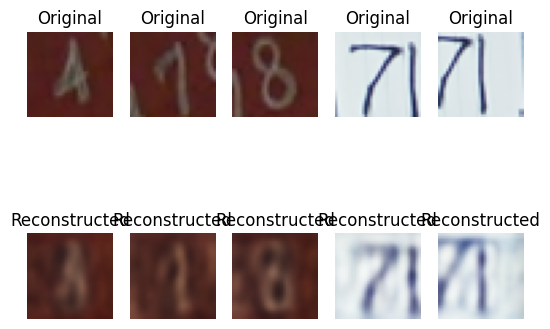

In [7]:
# Show original and reconstructed images for a few samples
num_display = 5
with torch.no_grad():
    for data in test_loader:
        inputs, _ = data
        noisy_inputs = inputs + 0.2 * torch.randn_like(inputs)
        outputs = autoencoder(noisy_inputs)

        for i in range(num_display):
            plt.subplot(2, num_display, i + 1)
            plt.imshow(inputs[i].permute(1, 2, 0).numpy() / 2 + 0.5)
            plt.title('Original')
            plt.axis('off')

            plt.subplot(2, num_display, i + num_display + 1)
            plt.imshow(outputs[i].permute(1, 2, 0).numpy() / 2 + 0.5)
            plt.title('Reconstructed')
            plt.axis('off')

        break

plt.show()